# HDBSCAN Clustering for RBD sequences - Omicron Only

Take a look at the clusters and the pango lineages in them (above).
- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

---
### Omicron only (all available) - From MSA

One-Hot

In [9]:
from Bio import AlignIO
import numpy as np

alignment = AlignIO.read("/data/spike_ml/Spike_NLP-Lightning_martha/Spike_NLP-Lightning/notebooks/phylogenetic_analysis/aligned_ADO_seq.afasta", "fasta")

# Filter records by variant (Omicron only)
filtered_alignment = [record for record in alignment if record.description.split("|")[1].strip() == "Omicron"]

aas = "ACDEFGHIKLMNPQRSTVWY-"  # include gap
aa_to_idx = {aa: i for i, aa in enumerate(aas)}

# One-Hot Encoding
n_seq = len(filtered_alignment)
align_len = alignment.get_alignment_length()    # seq length should not change post filtering
X = np.zeros((n_seq, align_len * len(aas)), dtype=np.int8)

for i, record in enumerate(filtered_alignment):
    for j, aa in enumerate(str(record.seq)):
        X[i, j * len(aas) + aa_to_idx.get(aa, 20)] = 1  # unknown -> gap index

np.savez_compressed("msa_o_X.compressed.npz", X=X)

Match sampling by extracting certain records, combine with the metadata.

In [10]:
import os
import pandas as pd

data_dir = "../../../data/rbd"
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O.from-esm-mlm.CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedded_o_df = embedded_o_df.drop(columns=["AA Substitutions", "embedding"])
embedded_o_df.head(5)

,seq_id,variant,Pango lineage,Location,Collection date
0,EPI_ISL_14904955,Omicron,BA.5.5,North America / USA / Maryland,2022-08-22
1,EPI_ISL_14904971,Omicron,BA.5.6,North America / USA / California,2022-08-22
2,EPI_ISL_14906096,Omicron,BA.5.1.10,North America / USA / New York,2022-08-27
3,EPI_ISL_14906051,Omicron,BA.5.2.18,North America / USA / Maryland,2022-08-27
4,EPI_ISL_14906040,Omicron,BA.5.2.9,North America / USA / Michigan,2022-08-26


In [11]:
import pandas as pd

# Extract (ID, description) for each sequence
metadata = [(record.id, record.description.split("|")[1].strip(), record.description.split("|")[2].strip()) for record in alignment]

# Convert to DataFrame
df = pd.DataFrame(metadata, columns=["seq_id", "variant", "Pango lineage"])

# Merge the dfs
merged_df = pd.merge(embedded_o_df, df, on=["seq_id", "variant", "Pango lineage"], how="inner")
merged_df

,seq_id,variant,Pango lineage,Location,Collection date
0,EPI_ISL_14904955,Omicron,BA.5.5,North America / USA / Maryland,2022-08-22
1,EPI_ISL_14904971,Omicron,BA.5.6,North America / USA / California,2022-08-22
2,EPI_ISL_14906096,Omicron,BA.5.1.10,North America / USA / New York,2022-08-27
3,EPI_ISL_14906051,Omicron,BA.5.2.18,North America / USA / Maryland,2022-08-27
4,EPI_ISL_14906040,Omicron,BA.5.2.9,North America / USA / Michigan,2022-08-26
...,...,...,...,...,...
160011,EPI_ISL_12987713,Omicron,BA.2.10,Asia / Japan / Hyogo,2022-05-03
160012,EPI_ISL_14903692,Omicron,BF.5,North America / USA / California / Alameda County,2022-07-30
160013,EPI_ISL_14902388,Omicron,BA.4.6,North America / USA / California,2022-08-22
160014,EPI_ISL_14905423,Omicron,BA.5.6,North America / USA / New Jersey,2022-08-22


Apply tSNE to the embeddings.

In [13]:
import time 
from openTSNE import TSNE

# Apply tSNE
perp = round(len(merged_df) * 0.01)
print(perp) 

start_time = time.perf_counter()

tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=64)
embedding_matrix_reduced = tsne_reducer.fit(X)

end_time = time.perf_counter()  # End timing
elapsed = end_time - start_time
print(f"Perplexity {perp}: Time taken = {elapsed:.2f} seconds")

# Save the embedding
plot_df = pd.DataFrame({
    't-SNE component 1': embedding_matrix_reduced[:, 0],
    't-SNE component 2': embedding_matrix_reduced[:, 1],
    'Seq ID': merged_df['seq_id'],
    'Variant': merged_df['variant'],
    'Pango lineage': merged_df['Pango lineage'],
    'Collection date': merged_df['Collection date'] 
})
save_as = f"RBD.O.MSA.tSNE-perplexity{perp}.parquet"
plot_df.to_parquet(save_as, engine='fastparquet')

1600
Perplexity 1600: Time taken = 2442.43 seconds


Find the highest Silhouette Coefficient (Adjusted Rand Index will be 0, since it is all Omicron).

min_sample 1000, min_cluster_size 4000: Silhouette Coefficient: 0.69
min_sample 1000, min_cluster_size 4500: Silhouette Coefficient: 0.70
min_sample 1000, min_cluster_size 5000: Silhouette Coefficient: 0.70
min_sample 1000, min_cluster_size 6000: Silhouette Coefficient: 0.68
min_sample 1000, min_cluster_size 7000: Silhouette Coefficient: 0.68
min_sample 1250, min_cluster_size 4000: Silhouette Coefficient: 0.69
min_sample 1250, min_cluster_size 4500: Silhouette Coefficient: 0.69
min_sample 1250, min_cluster_size 5000: Silhouette Coefficient: 0.69
min_sample 1250, min_cluster_size 6000: Silhouette Coefficient: 0.68
min_sample 1250, min_cluster_size 7000: Silhouette Coefficient: 0.68
min_sample 1500, min_cluster_size 4000: Silhouette Coefficient: 0.69
min_sample 1500, min_cluster_size 4500: Silhouette Coefficient: 0.69
min_sample 1500, min_cluster_size 5000: Silhouette Coefficient: 0.69
min_sample 1500, min_cluster_size 6000: Silhouette Coefficient: 0.69
min_sample 1500, min_cluster_size 

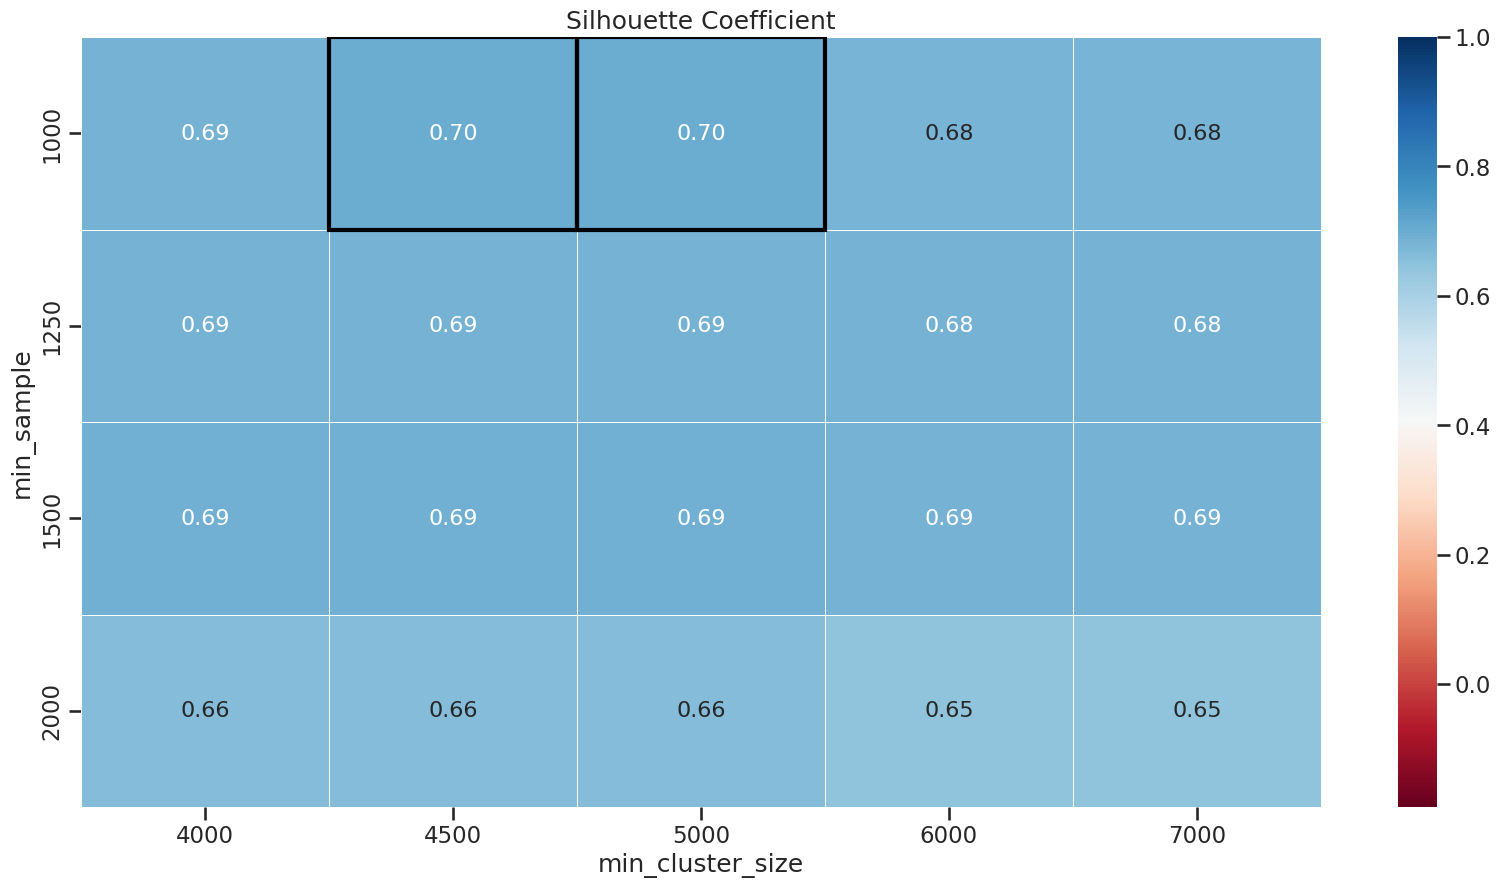

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
import hdbscan
from sklearn.metrics import silhouette_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(parquet_file, perp):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    start_time = time.perf_counter()

    results = []
    for ms in [1000, 1250, 1500, 2000]:
        for mcs in [4000, 4500, 5000, 6000, 7000]:
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix)

            labels = clusterer.labels_

            # Evaluate clustering
            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "silhouette": silhouette_avg
            })

            print(f"min_sample {ms}, min_cluster_size {mcs}: Silhouette Coefficient: {silhouette_avg:.2f}")

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(20, 10))

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", vmin=-0.19, vmax=1)
    plt.title("Silhouette Coefficient")
    plt.xlabel("min_cluster_size")
    plt.ylabel("min_sample")

    max_sc = silhouette_matrix.max().max()  # Get the max ARI value

    for i in range(silhouette_matrix.shape[0]):  # min_sample (rows)
        for j in range(silhouette_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(silhouette_matrix.iloc[i, j], max_sc):  # Safe float comparison
                ax.add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )
    save_as = parquet_file.replace(".parquet", ".HDBSCAN_heatmap")
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

perp = 1600
parquet_file = f"RBD.O.MSA.tSNE-perplexity{perp}.parquet"
ari_sc_heatmap(parquet_file, perp)

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 1000, min_cluster_size 4500: Adjusted Rand Index: 0.00, Silhouette Coefficient: 0.70


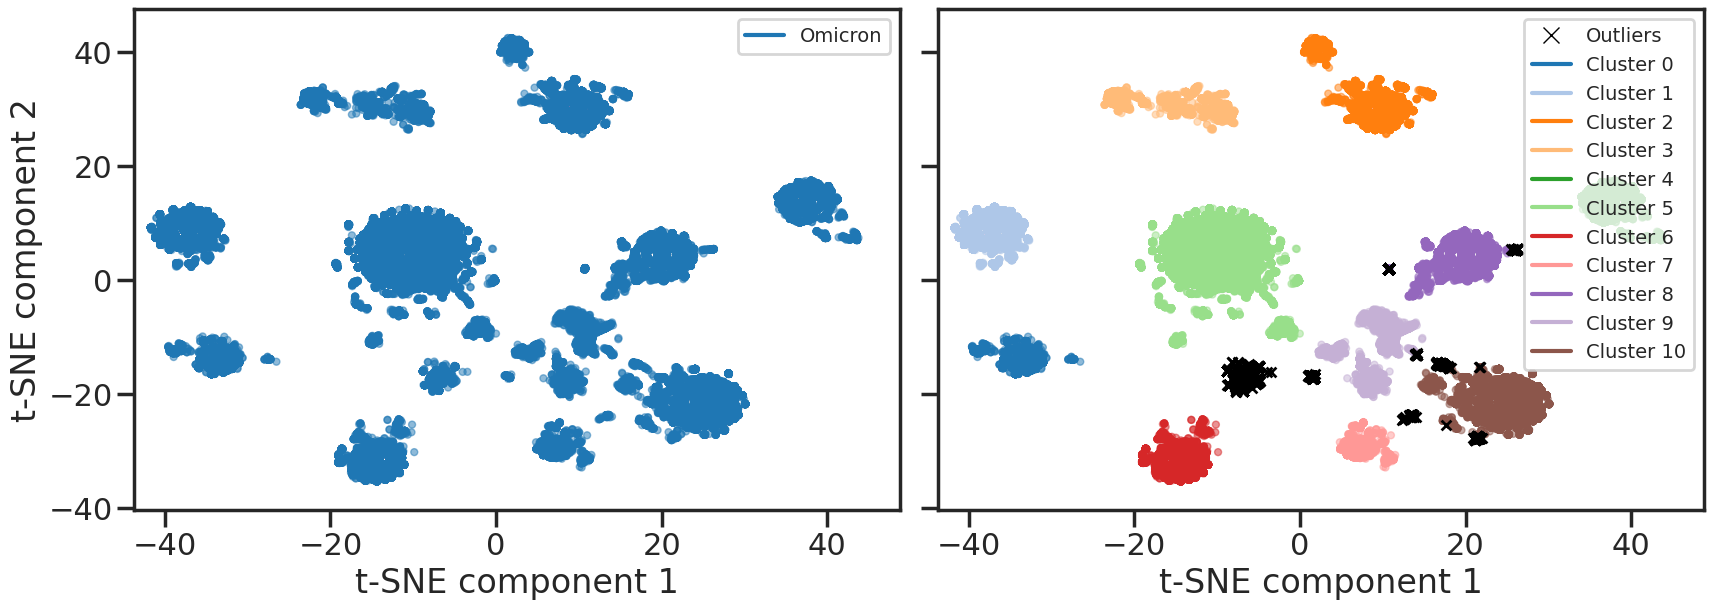

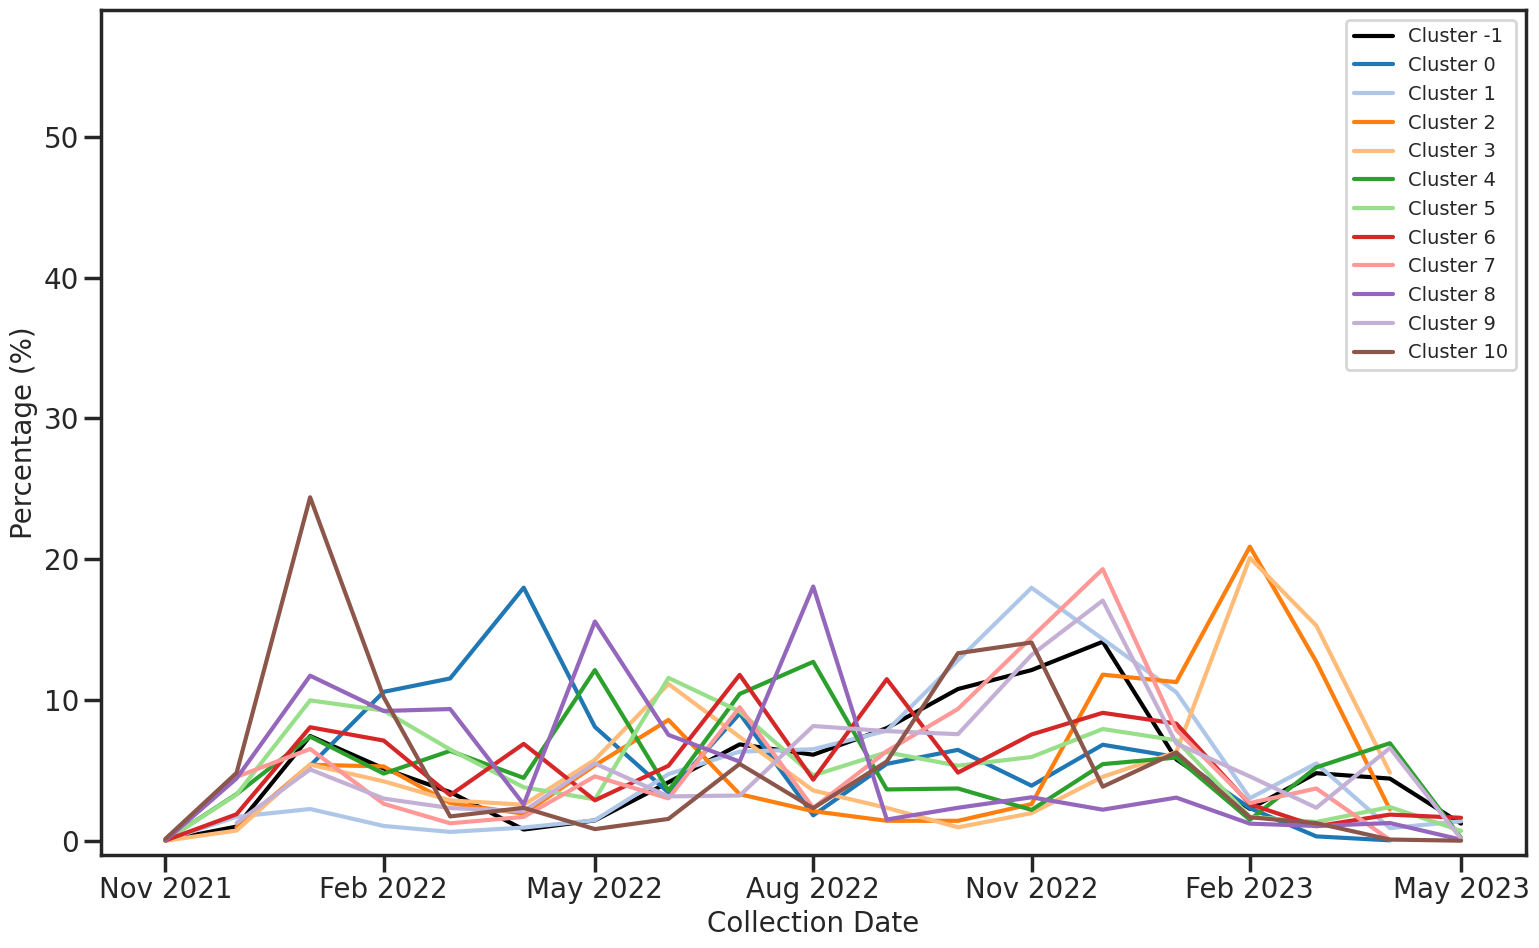

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9,10
Ground Truth,,,,,,,,,,,,
Omicron,3.58,5.52,7.69,9.8,6.83,7.48,22.15,6.95,3.56,8.75,6.04,11.65


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.dates as mdates

def cluster_date_collected(plot_df, save_as, colormap):
    """ Calculate variant percentages over collection dates within clusters and plot them in a single plot. """
    
    # Copy the DataFrame to avoid modifying the original
    df = plot_df.copy()

    # Define cluster color mapping, with outliers (Cluster -1) as black
    unique_clusters = np.unique(df['Cluster'])
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'Variant']).size().reset_index(name='Cluster count')

    # Calculate total count within each cluster
    total_cluster_count = df.groupby(['Cluster']).size().reset_index(name='Total count')
    cluster_date_counts = cluster_date_counts.merge(total_cluster_count, on='Cluster')

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / cluster_date_counts['Total count']) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Create a single plot with all clusters and variants
    sns.set_style('ticks')
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 10))

    # Plot each cluster-variant pair in the same plot, applying color mapping
    for (cluster_label, variant), grouped_df in cluster_date_counts.groupby(['Cluster', 'Variant']):
        ax.plot(grouped_df['YearMonth'].dt.to_timestamp(), 
                grouped_df['Cluster %'], 
                label=f"Cluster {cluster_label}",
                color=cluster_color_dict[cluster_label],  # Apply cluster-specific color
                linewidth=3)

    fontsize = 20
    ax.set_xlabel('Collection Date', fontsize=fontsize)
    ax.set_ylabel(f'Percentage (%)', fontsize=fontsize)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.legend(loc='upper right', fontsize=fontsize-6, bbox_to_anchor=(1, 1))

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim(-1, 59)
    plt.tight_layout()
    plt.savefig(save_as + ".timescale.pdf", format="pdf")
    plt.savefig(save_as + ".timescale.png", format="png")
    plt.show()

def get_hdbscan_values(parquet_file, min_samples, min_cluster_size):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    # Cluster
    hdb_labels = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        core_dist_n_jobs=-1  # Enable parallel processing
    ).fit(embedding_matrix).labels_

    # Evaluate clustering
    silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
    ari = adjusted_rand_score(embedded_df["Variant"], hdb_labels)
    print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Create the truth table
    truth_table_percent = pd.crosstab(embedded_df["Variant"], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100).round(2)

    # Save
    plot_df = pd.DataFrame({
        't-SNE component 1': embedded_df['t-SNE component 1'],
        't-SNE component 2': embedded_df['t-SNE component 2'],
        'Cluster': hdb_labels,
        'Seq ID': embedded_df['Seq ID'],
        'Variant': embedded_df['Variant'],
        'Pango lineage': embedded_df['Pango lineage'],
        'Collection date': embedded_df['Collection date']
    })    
    save_as = parquet_file.replace(".parquet", f".HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}")
    plot_df.to_parquet(f"{save_as}.parquet", engine='fastparquet')
    
    return plot_df, truth_table_percent, save_as

def plot_groundtruth_prediction_1x2(plot_df, save_as, x_min_width_buffer, x_max_width_buffer, y_min_width_buffer, y_max_width_buffer, color_map, cluster_color_palette_order):
    marker_size = 25
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(color_map, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(color_map, n_colors=20) 
    cluster_color_palette = [cluster_color_palette[i] for i in cluster_color_palette_order]
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20.25, 6.5), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[0]
    )

    # axs[0].set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-y_min_width_buffer, plot_df['t-SNE component 2'].max()+y_max_width_buffer),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles)
    sns.move_legend(axs[0], "upper right", fontsize=14)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
        ax=axs[1]
    )

    # axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles)
    sns.move_legend(axs[1], "upper right", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

perp = 1600
parquet_file = f"RBD.O.MSA.tSNE-perplexity{perp}.parquet"

min_samples=1000
min_cluster_size=4500
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)

# Call the function
plot_groundtruth_prediction_1x2(
    plot_df, save_as, 
    x_min_width_buffer=2, x_max_width_buffer=5, y_min_width_buffer=5, y_max_width_buffer=5, 
    color_map="tab20", cluster_color_palette_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
)
cluster_date_collected(plot_df, save_as, "tab20")

truth_table_percent

In [7]:
def cluster_pango_lineage(plot_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = plot_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'Variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])

    # Drop unwanted columns
    lineage_counts = lineage_counts.drop(columns=[
        # 'Cluster count', 
        'Total count'
    ])

    # Filter out lineages with cluster% < 1%
    lineage_counts = lineage_counts[lineage_counts['Cluster %'] >= 1]

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Cluster info
result = cluster_pango_lineage(plot_df)
result.to_csv(f"RBD.O.MSA.tSNE-perplexity1600.lineage_clusters.csv", index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)
for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

    Cluster  Variant Pango lineage  Cluster count  Cluster %  Lineage %
0        -1  Omicron       BA.5.2*            695  12.143980   4.363659
1        -1  Omicron    Unassigned            665  11.619780  10.308479
2        -1  Omicron       BQ.1.1*            479   8.369736   4.423308
3        -1  Omicron          BA.2            398   6.954395   2.856528
4        -1  Omicron       BA.1.1*            381   6.657348   2.932574
5        -1  Omicron      XBB.1.5*            291   5.084746   3.564866
6        -1  Omicron       BA.5.1*            255   4.455705   3.340320
7        -1  Omicron      BA.2.12*            115   2.009436   2.153961
8        -1  Omicron       CH.1.1*             96   1.677442   3.654359
9        -1  Omicron          BF.5             93   1.625022   3.876615
10       -1  Omicron          BA.1             88   1.537655   1.645475
11       -1  Omicron       BE.1.1*             86   1.502708   7.445887
12       -1  Omicron       BA.4.6*             80   1.397868   3

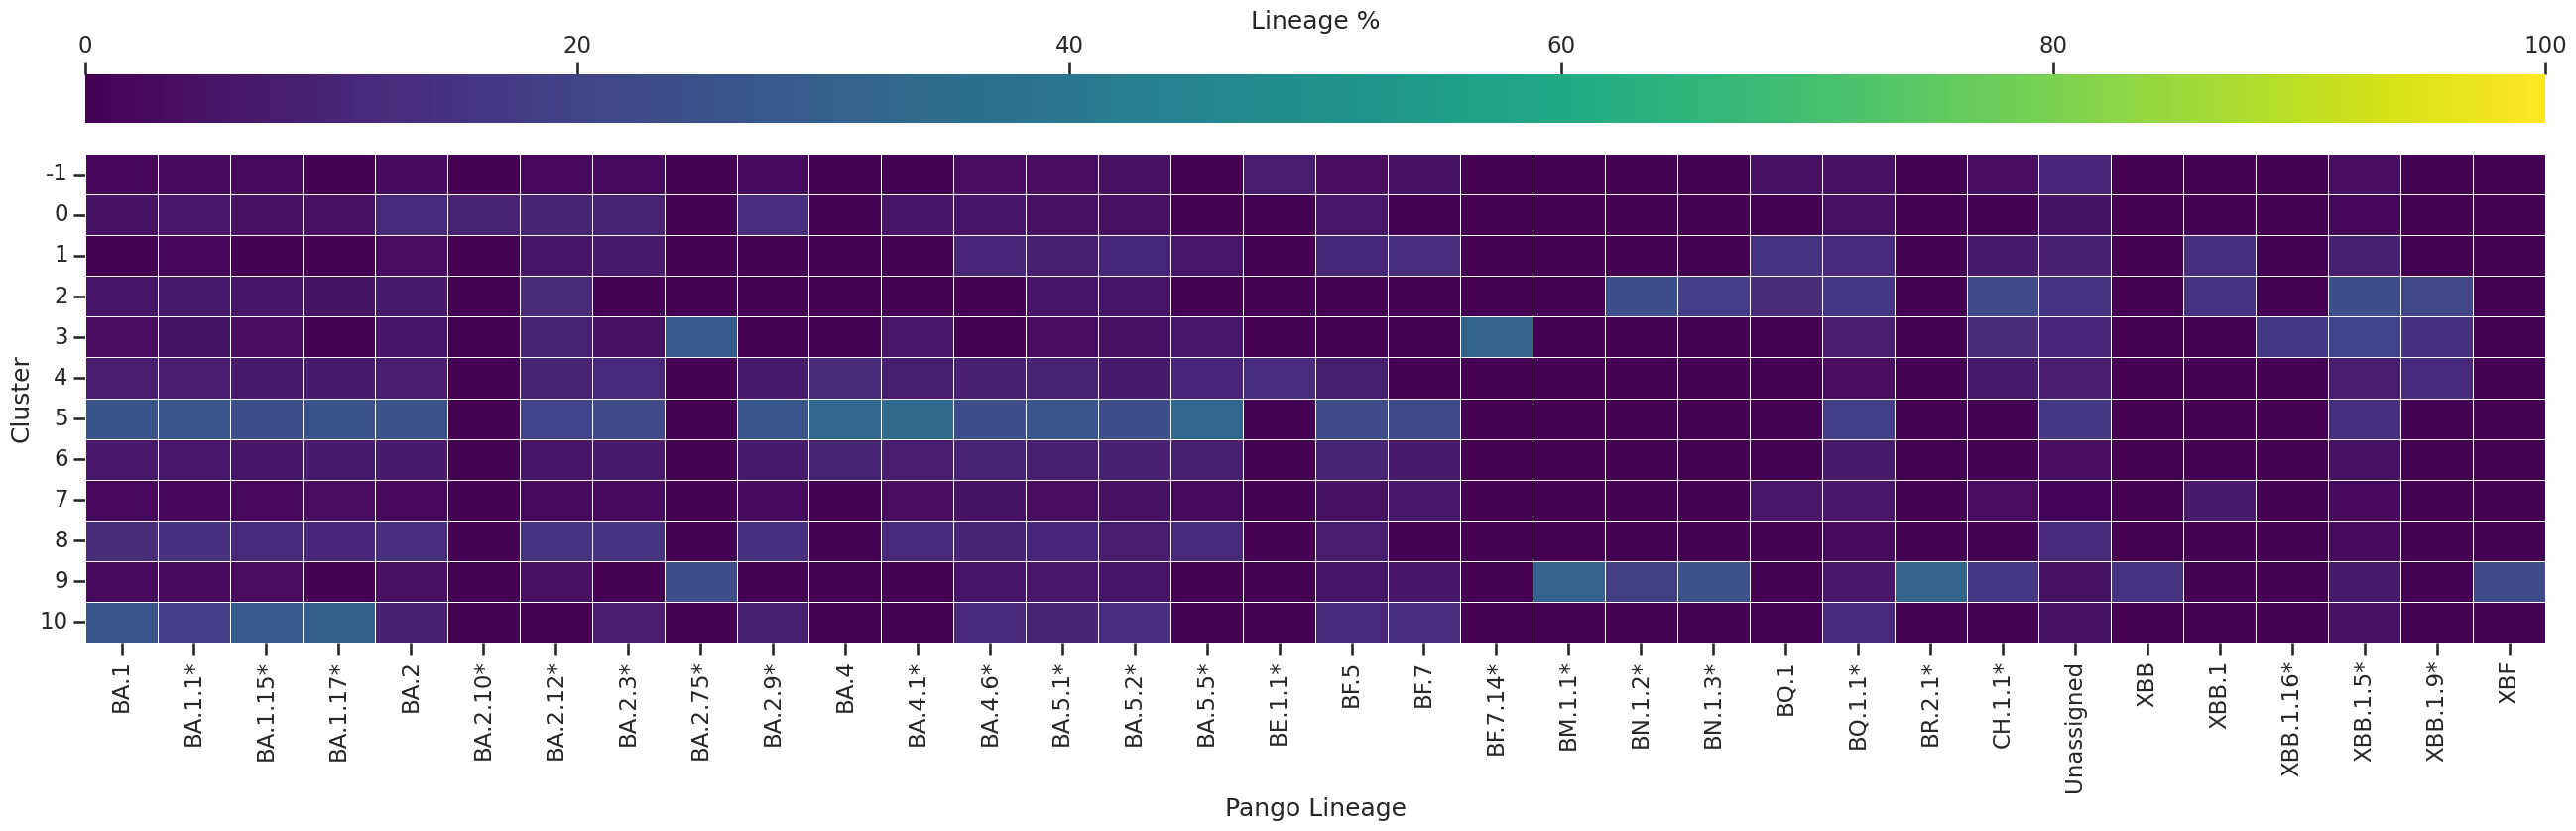

In [8]:
df = cluster_pango_lineage(plot_df)

# Pivot matrices
heatmap_matrix = df.pivot(index='Cluster', columns='Pango lineage', values='Lineage %').fillna(0)    # cluster as y axis

# Plot heatmaps
sns.set_style('ticks')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(32, 8))

ax = sns.heatmap(
    heatmap_matrix, annot=False, linewidth=.5, cmap="viridis", vmin=0, vmax=100, xticklabels=True, yticklabels=True,
    cbar_kws={"orientation": "horizontal", "aspect": 50, "location":"top", "label": "Lineage %"}  
)

# Move colorbar to the top
plt.xlabel("Pango Lineage")
plt.ylabel("Cluster")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Save
perp = 1600
save_as = f"RBD.O.MSA.tSNE-perplexity{perp}.lineage_perc_heatmap_horizontal"
plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

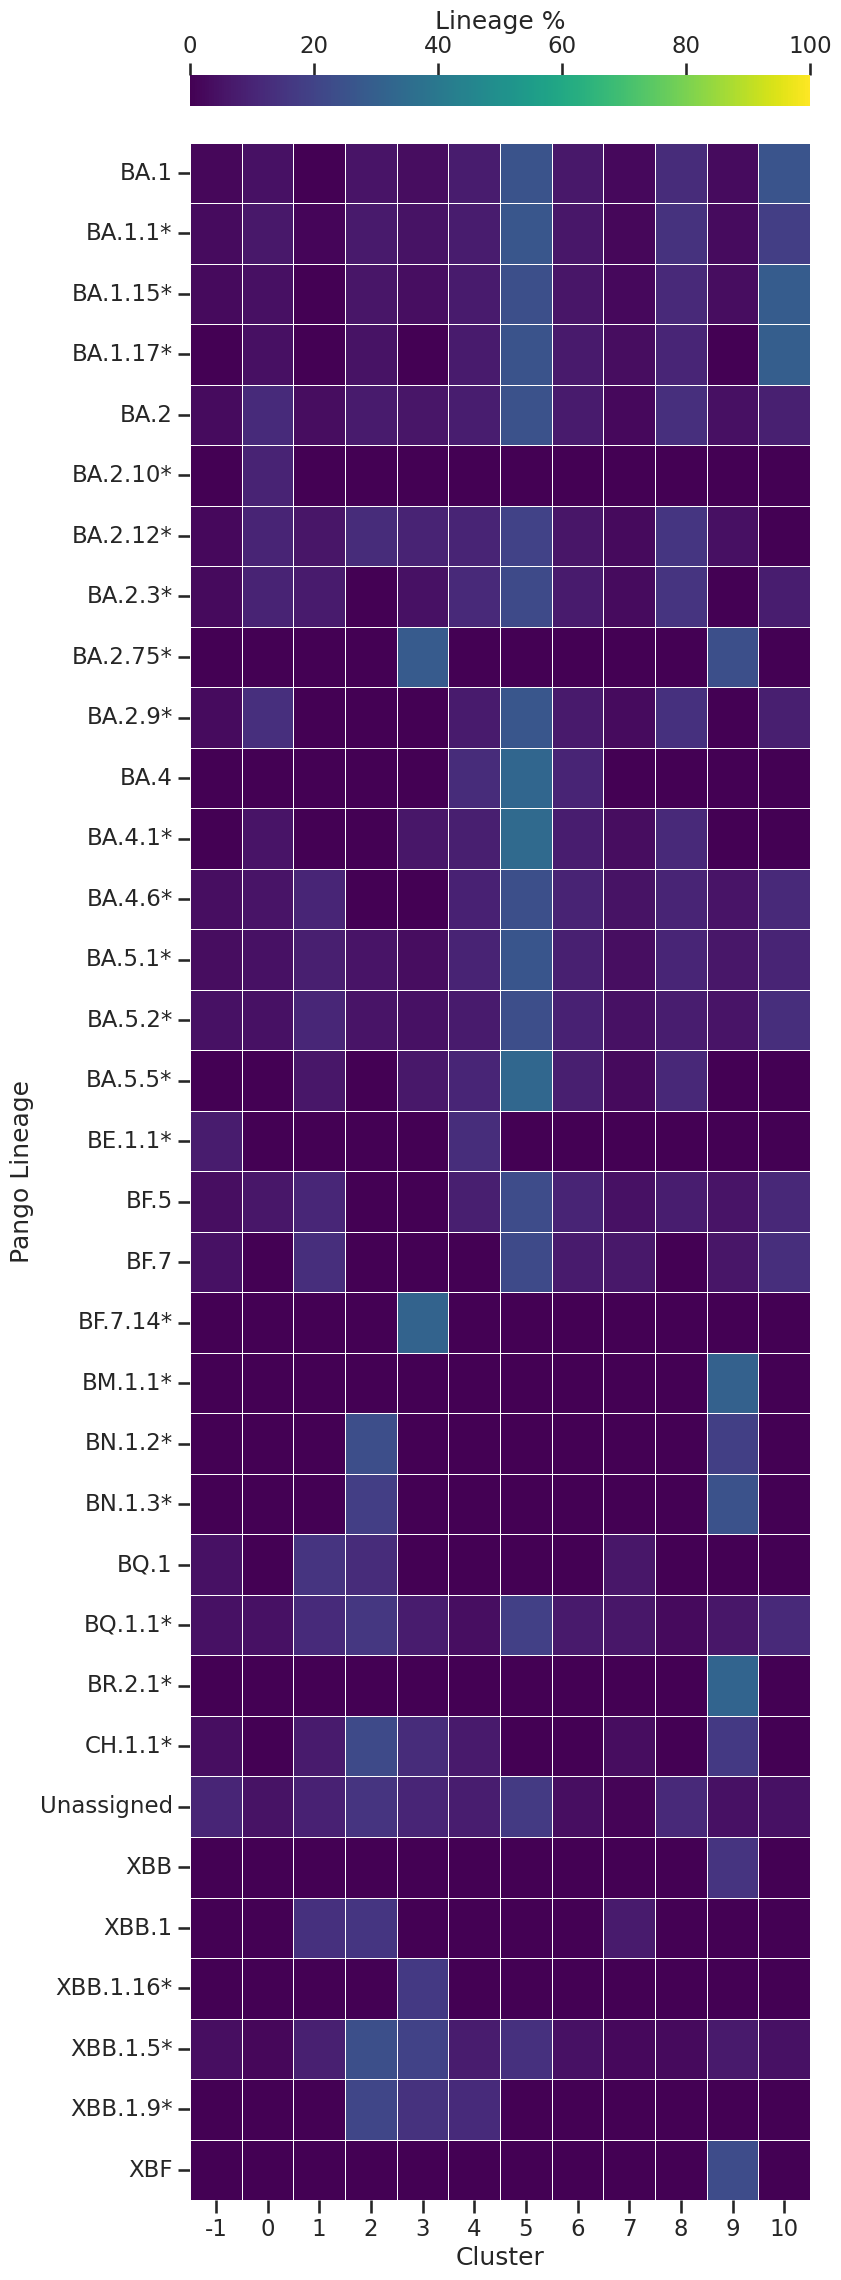

In [9]:
df = cluster_pango_lineage(plot_df)

# Pivot matrices
heatmap_matrix = df.pivot(index='Pango lineage', columns='Cluster', values='Lineage %').fillna(0)     # cluster as x axis

# Plot heatmaps
sns.set_style('ticks')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(8, 32))

ax = sns.heatmap(
    heatmap_matrix, annot=False, linewidth=.5, cmap="viridis", vmin=0, vmax=100, xticklabels=True, yticklabels=True,
    cbar_kws={"orientation": "horizontal", "aspect": 20, "pad": 0.015, "location":"top", "label": "Lineage %"}
)

# Move colorbar to the top
plt.xlabel("Cluster")
plt.ylabel("Pango Lineage")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Save
perp = 1600
save_as = f"RBD.O.MSA.tSNE-perplexity{perp}.lineage_perc_heatmap_vertical"
plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()